# Convolutional Neural Network Model

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow import argmax

from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import Dense
from keras.layers import Input
from keras.layers import Convolution1D
from keras.layers import MaxPool1D
from keras.layers import Flatten
from keras.layers import Dropout

In [6]:
beatLen_cuttoff = 700; 
num_classes = 5;
beatTypes = {
    'N': 0, 
    'L': 1, 
    'R': 2, 
    'A': 3, 
    'V': 4
}

## Import and balance the data

In [7]:
HB_data = np.loadtxt('beats_list.csv',delimiter=',')

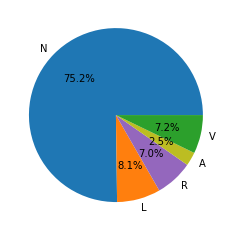

In [14]:
plot_pieChart(HB_data,num_classes)

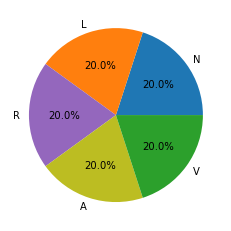

In [15]:
HB_data_bal = balance_classes(HB_data,num_classes, 5000, True)
plot_pieChart(HB_data_bal,num_classes)

In [16]:
X = HB_data_bal[:, :beatLen_cuttoff];
Y = HB_data_bal[:,  -1];

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3);

In [17]:
Y_train_c = to_categorical(Y_train, num_classes=num_classes);
Y_test_c = to_categorical(Y_test, num_classes =num_classes);

## Neural Network Model Definition and Training

In [73]:
model = Sequential();

model.add(Convolution1D(100,6,activation='relu', input_shape = (beatLen_cuttoff,1)))
model.add(BatchNormalization())

model.add(Convolution1D(80,3,activation ='relu'))
model.add(BatchNormalization())
model.add(Convolution1D(40,1,activation ='relu'))
model.add(MaxPool1D(pool_size=20))
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50,activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(5, activation='sigmoid'))

model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
history = model.fit(X_train,Y_train_c,epochs=20, callbacks = callbacks, validation_data=(X_test,Y_test_c))
model.load_weights('best_model.h5')


Epoch 1/20
547/547 [==============================] - 7s 11ms/step - loss: 0.3103 - accuracy: 0.8963 - val_loss: 0.3334 - val_accuracy: 0.9449
Epoch 2/20
547/547 [==============================] - 6s 10ms/step - loss: 0.1374 - accuracy: 0.9551 - val_loss: 0.1297 - val_accuracy: 0.9564
Epoch 3/20
547/547 [==============================] - 6s 10ms/step - loss: 0.1080 - accuracy: 0.9638 - val_loss: 0.1203 - val_accuracy: 0.9632
Epoch 4/20
547/547 [==============================] - 6s 11ms/step - loss: 0.0846 - accuracy: 0.9721 - val_loss: 0.1347 - val_accuracy: 0.9509
Epoch 5/20
547/547 [==============================] - 6s 10ms/step - loss: 0.0665 - accuracy: 0.9785 - val_loss: 0.0779 - val_accuracy: 0.9756
Epoch 6/20
547/547 [==============================] - 6s 10ms/step - loss: 0.0629 - accuracy: 0.9787 - val_loss: 0.0713 - val_accuracy: 0.9787
Epoch 7/20
547/547 [==============================] - 6s 10ms/step - loss: 0.0529 - accuracy: 0.9823 - val_loss: 0.0815 - val_accuracy: 0.9729

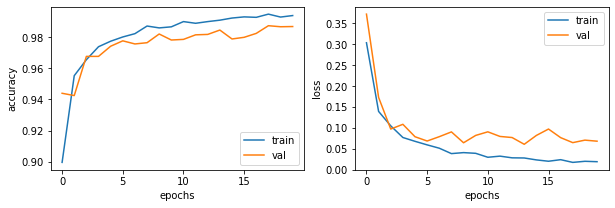

In [66]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
for i,met in enumerate(['accuracy','loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train','val'])
plt.show()

In [67]:
Y_pred_c = model.predict(X_test)

235/235 [==============================] - 1s 3ms/step


In [68]:
Y_pred = list(map(np.argmax,Y_pred_c))

## Model Accuracy

In [69]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy: %0.2f"%(accuracy_score(Y_test, Y_pred)*100))
print("Accuracy: %0.2f"%(f1_score(Y_test, Y_pred, average='macro')))

Accuracy: 98.47
Accuracy: 0.98


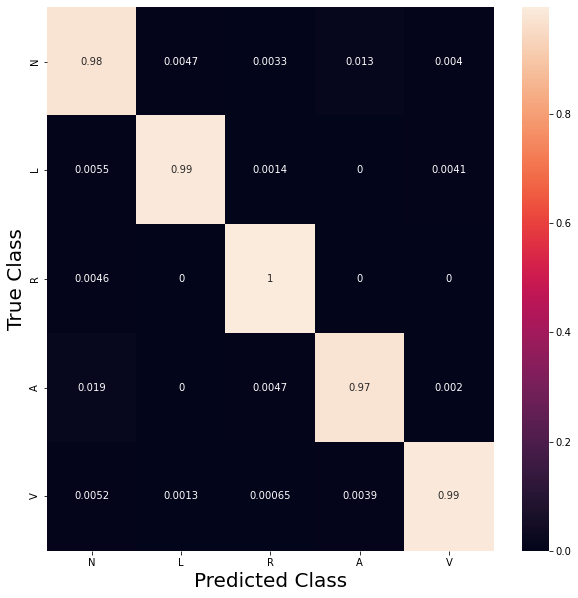

In [72]:
cm = confusion_matrix(Y_test, Y_pred, normalize='true')
df_cm = pd.DataFrame(cm, index = [i for i in beatTypes],
              columns = [i for i in beatTypes])

plt.figure(figsize = (10,10));
sn.heatmap(df_cm, annot=True);

plt.ylabel('True Class', size =20);
plt.xlabel('Predicted Class',size = 20);

## Some helpful functions

In [11]:
def balance_classes(HB_data,num_classes, samples_per_class = 2500, replace = False):
    rng = np.random.default_rng()
    cols = np.shape(HB_data)[1]
    HB_data_subSamp = np.zeros((samples_per_class*num_classes,cols));
    for ii in range(num_classes):
        index = HB_data[:,-1] == ii;
        HB_ii = HB_data[HB_data[:,-1] == ii,:];
        start = ii*samples_per_class
        end = start+samples_per_class
        HB_data_subSamp[start:end,:] = rng.choice(HB_ii, samples_per_class, replace = replace)
    return HB_data_subSamp;  

In [12]:
def plot_pieChart(data, num_classes):
    class_counts = get_classCounts(data, num_classes);
    plt.pie(class_counts, labels=beatTypes, colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
    plt.show()

In [13]:
def get_classCounts(data, num_classes):
    classCounts = map(lambda ii: sum(data[:,-1] == ii), range(num_classes))
    return list(classCounts)